In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
import matplotlib.pyplot as plt

L1_SIZE       = 10            # How many nodes in layer 1
EPOCHS        = 10
TEST_PCT      = 0.15
FEATURE_COUNT = 2
LEARNING_RATE = .01
SUMMARIES_DIR = '/home/tom/tf_logs' # where to store Tensorboard data
LAMBDA        = 0.              # Regularization parameter

In [2]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, dtype=tf.float32))

#### Get the data

In [3]:
if sys.platform[:3] =='win':
    data_loc = 'D:/Data/'
else:
    data_loc = "/home/tom/data/"

filenm = "haganCaseStudy1.csv"
df = pd.read_csv(data_loc+filenm, delimiter = ',')

# v1 and v2 is the voltage coming out of the 2 solar cells
# y is the position of the ping pong ball (in front of a light)
df.head()

,v1,v2,y
0,2.66,4.44,0.00
1,1.98,4.43,0.06
2,1.44,4.43,0.11
3,0.71,4.43,0.18
4,0.46,4.41,0.20


In [4]:
# Standardize the data
v1     = df['v1'].values.reshape(-1,1)
v1_std = StandardScaler().fit_transform(v1)
v2     = df['v2'].values.reshape(-1,1)
v2_std = StandardScaler().fit_transform(v2)
y      = df['y'].values.reshape(-1,1)
y_std  = StandardScaler().fit_transform(y)

In [5]:
# Split into train and test
# Recombine into DF
arr = np.concatenate([v1_std,v2_std,y_std], axis=1)
cols = ['v1','v2','y']
df = pd.DataFrame(arr, columns=cols)

train, test = train_test_split(df, test_size=TEST_PCT)

In [6]:
X = train[['v1', 'v2']]
Y = train[['y']]
X_test = test[['v1', 'v2']]
Y_test = test[['y']]

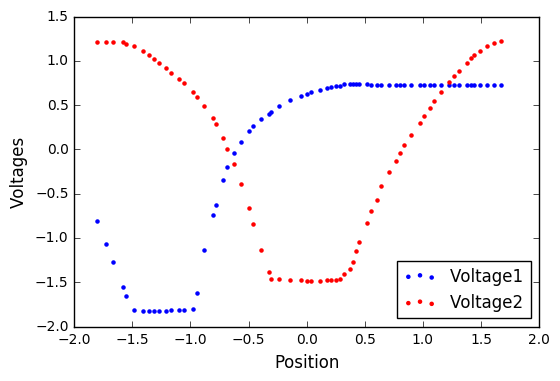

In [7]:
# See what the data looks like
a = plt.scatter(y_std, v1_std, s=5, color='blue',label='Voltage1')
b = plt.scatter(y_std, v2_std, s=5, color='red', label='Voltage2')
plt.legend(loc='lower right')
plt.xlabel('Position', fontsize=12)
plt.ylabel('Voltages', fontsize=12)
plt.show()

In [8]:
# Set up the network
tf.reset_default_graph()
x  = tf.placeholder("float", shape=[None, FEATURE_COUNT])
y_ = tf.placeholder("float", shape=[None, 1])

l1_w = init_weights([FEATURE_COUNT, L1_SIZE])
l1_b = init_weights([1, L1_SIZE])
l1_act = tf.nn.tanh(tf.matmul(x,l1_w + l1_b))

l2_w = init_weights([L1_SIZE, 1])
l2_b = init_weights([1,1])

l2_out = tf.matmul(l1_act, l2_w + l2_b)

#cost = tf.reduce_sum(tf.square(l2_out - y_))
cost = tf.div(tf.add(tf.reduce_sum(tf.square(l2_out - y_)),
                     tf.mul(LAMBDA, tf.reduce_sum(tf.square(l1_w)))),
              2*X.size)

# Optimizer
optimize = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

# Accuracy
score = tf.reduce_sum(tf.square(l2_out - y_))
tf.scalar_summary('score', score)

merged = tf.merge_all_summaries()

In [11]:
count = 1
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    train_writer = tf.train.SummaryWriter(SUMMARIES_DIR + '/train', sess.graph)
    for LAMBDA in np.linspace(0,.2,100):
        for i in range(EPOCHS):
            sess.run(optimize, feed_dict = {x: X, y_: Y})
        s, m = sess.run([score, merged], feed_dict = {x: X_test, y_: Y_test})
        print(s)
        train_writer.add_summary(m, count)
        count += 1
    #tom = sess.run(l2_out, feed_dict = {x: X_test, y_: Y_test})
    train_writer.close()

0.561366
0.457818
0.379939
0.320736
0.274457
0.240591
0.218109
0.204044
0.195088
0.189004
0.18459
0.181212
0.178456
0.175944
0.173323
0.1704
0.167203
0.163737
0.159842
0.155348
0.150259
0.144919
0.139936
0.135901
0.132813
0.13056
0.129394
0.132013
0.126114
0.12499
0.124199
0.114686
0.122766
0.123064
0.12353
0.12646
0.125325
0.12457
0.124981
0.1232
0.112758
0.117225
0.113316
0.109306
0.10563
0.102575
0.101588
0.174128
0.0970534
0.0965272
0.139768
0.0985905
0.0947369
0.0949141
0.102235
0.102614
0.111766
0.0961182
0.0925464
0.0922164
0.091576
0.0910444
0.0904448
0.0897725
0.087726
0.0902244
0.0869426
0.0854865
0.0842178
0.0825755
0.0800203
0.0841364
0.0754832
0.0724214
0.0692261
0.0656772
0.0624647
0.060581
0.0590937
0.0587063
0.0587826
0.05632
0.0574416
0.0570326
0.0970933
0.0588476
0.0615146
0.0653733
0.0703578
0.0757333
0.0831709
0.0866492
0.0913872
0.0936418
0.125777
0.104625
0.0956757
0.108639
0.108676
0.110911


In [13]:
# See what the data looks like
#plt.plot(X_test['v1'], tom, 'xb-')
a = plt.plot(X_test['v1'], tom,  color='blue',label='Prediction')
b = plt.plot(X_test['v1'],Y_test,  color='red',label='Actual')
plt.legend(loc='lower right')
plt.xlabel('Position', fontsize=12)
plt.ylabel('Voltages', fontsize=12)
plt.show()

NameError: name 'tom' is not defined